In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.signal import detrend
import numpy as np
from sklearn.decomposition import TruncatedSVD
import dask
import os
import geopandas as gpd
from joblib import Parallel, delayed
from shapely.geometry import Point
from tqdm import tqdm
from PyEMD import EEMD
eemd = EEMD()
from scipy.stats import zscore
import dask.array as da
import regionmask
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nclcmaps
import seaborn as sns
cmap1= nclcmaps.cmap('BlueWhiteOrangeRed')


# SCPDSI

using SCPDSI at 1 degree Resolution 
Data of scpdsi is Climatic Research Unit, University of East Anglia, UK
Time period of analysis is from 1901-2020(120 years of record)
latitude range is from 70N to 60S antartica has been left out to remove the influemce of Global warming.
SCPDSI has been detrened using along time dimesion using scipy.signal.detrend that uses default linear detrending.
followed by zscore Normalization.


In [2]:
scpdsi_nc = xr.open_dataset("filepath scpdsi").sel(time = slice('1901-01-01','2020-12-31'),lat = slice(70,-60)).groupby('time.year').mean('time').to_dataarray()

In [3]:
lat =scpdsi_nc.lat.values
lon =scpdsi_nc.lon.values
time =scpdsi_nc.year.values
SCPDSI = scpdsi_nc.values
SCPDSI_3D = SCPDSI.reshape(len(time),len(lat),len(lon))
SCPDSI_2D = SCPDSI.reshape(len(time),len(lat)*len(lon))
scpdsi_mask = ~np.isnan(SCPDSI_2D).all(axis=0)
SCPDSI_Non_Nan = SCPDSI_2D[:,scpdsi_mask]  
# ===========================================
SCPDSI_FINAL = detrend(SCPDSI_Non_Nan,axis=0)
# ------------------------------------------
SCPDSI_FINAL = zscore(SCPDSI_FINAL,axis=0)

shape = (SCPDSI_2D.shape)
A_k_array = np.empty(shape)
A_k_array[:] = np.nan
A_k_array[:,scpdsi_mask] = SCPDSI_FINAL
A_k_array = A_k_array.reshape(len(time),len(lat),len(lon))
SCPDSI_detrened_array = xr.DataArray(A_k_array,coords = [time,lat,lon],dims = ['time','lat','lon'])

# SST 
Monthly Means of Sea Surface Temperature
DATASET PROVIDER :NOAA Extended Reconstructed SST V5
TIME PERIOD 1901 to 2020
TEMPORAL RESOLUTION : Monthly 
SPATIAL RESOLUTION : s degree by 2 degree
Months Considered are (not boreal winter)  but all the months Boreal Winter DJF 
# SST HAS BEEN DETRENDE BY REMOVING SPATIAL MEAN AND THEN NORMALIZED USING ZSCORE 

In [4]:
SST = xr.open_dataset('filepath sst').sel(time = slice('1901-01-01','2020-12-31'),lat=slice(60,-30)).sst.groupby('time.year').mean('time')

In [5]:
SSTA = SST
lat = SSTA.lat.values
lon = SSTA.lon.values
time = SSTA.year.values
SSTA = SSTA.values
SSTA_3D = SSTA.reshape(len(time),len(lat),len(lon))
SSTA_2D = SSTA.reshape(len(time),len(lat)*len(lon))
SST_mask = ~np.isnan(SSTA_2D).all(axis=0)
SST_Non_Nan = SSTA_2D[:,SST_mask]
SST_Non_Nan_final = SST_Non_Nan - np.mean(SST_Non_Nan,axis=1).reshape(-1,1)
SST_Non_Nan_final = zscore(SST_Non_Nan_final,axis = 0)   
shape = (SSTA_2D.shape)
B_k_array = np.empty(shape)
B_k_array[:] = np.nan
B_k_array[:,SST_mask] = SST_Non_Nan_final
B_k_array = B_k_array.reshape(len(time),len(lat),len(lon))
SST_detrended_array = xr.DataArray(B_k_array,coords = [time,lat,lon],dims = ['time','lat','lon'])

In [6]:
A = SST_Non_Nan_final
B = SCPDSI_FINAL
print(A.shape)
print(B.shape)

(120, 5670)
(120, 15204)


In [7]:
def dask_multiplication(A,B):
    A = A.astype(np.float32)
    B = B.astype(np.float32)
    A = A.transpose()
    A_dask = da.from_array(A, chunks=(int(A.shape[0]), -1))
    B_dask = da.from_array(B, chunks=(-1, int(B.shape[1])))
    result = da.matmul(A_dask, B_dask)/A.shape[1]
    return result

def SVD_compressed(result):
    
    u, s, vt = np.linalg.svd(result,full_matrices=False)

    return u,s,vt


In [8]:
print("entered multiplication loop")
result = dask_multiplication(A,B)
result = result.compute()
print("DOING SVD")
u, s, vt = SVD_compressed(result)
VT = vt
U = u
S = s
V= VT.T

entered multiplication loop


DOING SVD


In [9]:
exp = S**2/np.sum(S**2)*100
print((exp[:1]))
print((exp[1:2]))
print((exp[2:3]))
print((exp[3:4]))

[37.59449]
[15.177872]
[7.666449]
[6.0885916]


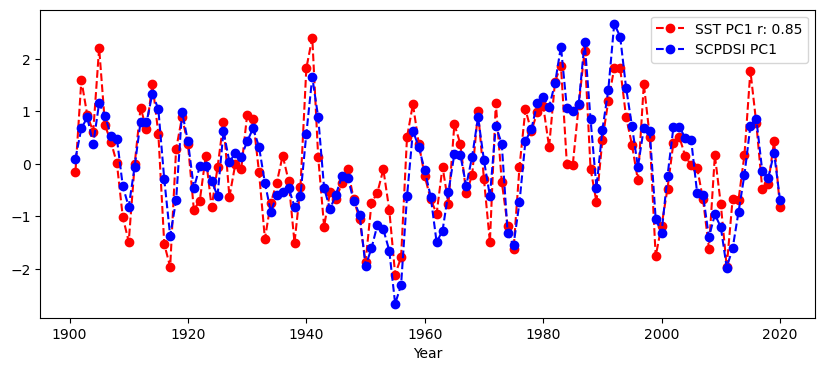

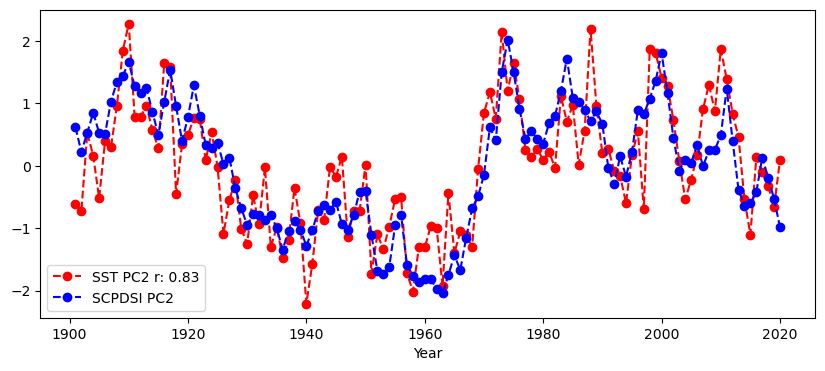

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from scipy.stats import linregress
for i in range(2):
    T_k_U_1 = np.matmul(A,U[:,i])
    T_K_V_1 = np.matmul(B,V[:,i])

    years = np.arange(1901,2021)
    Texp_A_0 = scaler.fit_transform(T_k_U_1.reshape(-1,1)*-1)
    Texp_B_0 = scaler.fit_transform(T_K_V_1.reshape(-1,1)*-1)
    _, _, r_value, _, _ = linregress(T_k_U_1,T_K_V_1)
    plt.figure(figsize=(10, 4))
    plt.plot(years, Texp_A_0, label=f'SST PC{i + 1} r: {r_value:.2f}', linestyle='--', color='red',marker='o')
    plt.plot(years, Texp_B_0, label=f'SCPDSI PC{i + 1}', linestyle='--',  color='blue',marker='o')
    plt.xlabel('Year')
    plt.legend()
    plt.show()


In [18]:
data_dict = {}
for i in [0, 1, 2, 3, 5, 7]:
        continents = gpd.read_file('filepath continenet shapefiles').iloc[[i]]
        polymask = regionmask.Regions(list(continents.explode().geometry))
        continent_ds = polymask.mask(SCPDSI_detrened_array)
        continent_ds = SCPDSI_detrened_array.where(np.isfinite(continent_ds))
        data_dict[continents.CONTINENT.values[0]] = continent_ds
    

In [11]:
def calculate_correlations(T_k_U, SST_yearly):
    lat_len, lon_len = len(SST_yearly["lat"]), len(SST_yearly["lon"])
    correlations = np.full((lat_len, lon_len), np.nan)
    SST_yearly_array = SST_yearly.values
    SST_yearly_array = SST_yearly_array.reshape(len(SST_yearly.time),len(SST_yearly.lat),len(SST_yearly.lon))

    for i in range(lat_len):
        for j in range(lon_len):
            y = SST_yearly_array[:, i, j]

            # If the first value is NaN, set the correlation to NaN
            if np.isnan(y[0]):
                correlations[i, j] = np.nan
            else:    
                _, _, r_value, pval, _ = linregress(T_k_U, y)
                if pval<0.05:
                    correlations[i, j] = r_value
                else:
                    correlations[i, j] = np.nan
                correlations[i, j] = r_value
    
    return xr.DataArray(
        correlations,
        dims=["lat", "lon"],
        coords={
            "lat": SST_yearly.coords["lat"],
            "lon": SST_yearly.coords["lon"],
        },
    )

In [12]:
def calculate_pval(T_k_U, SST_yearly):
    lat_len, lon_len = len(SST_yearly["lat"]), len(SST_yearly["lon"])
    prob = np.full((lat_len, lon_len), np.nan)
    SST_yearly_array = SST_yearly.values
    SST_yearly_array = SST_yearly_array.reshape(len(SST_yearly.time),len(SST_yearly.lat),len(SST_yearly.lon))

    for i in range(lat_len):
        for j in range(lon_len):
            y = SST_yearly_array[:, i, j]

            # If the first value is NaN, set the correlation to NaN
            if np.isnan(y[0]):
                prob[i,j] = np.nan
            else:    
                _, _, r_value, pval, _ = linregress(T_k_U, y)
                prob[i,j] = pval
    
    return xr.DataArray(
        prob,
        dims=["lat", "lon"],
        coords={
            "lat": SST_yearly.coords["lat"],
            "lon": SST_yearly.coords["lon"],
        },
    )

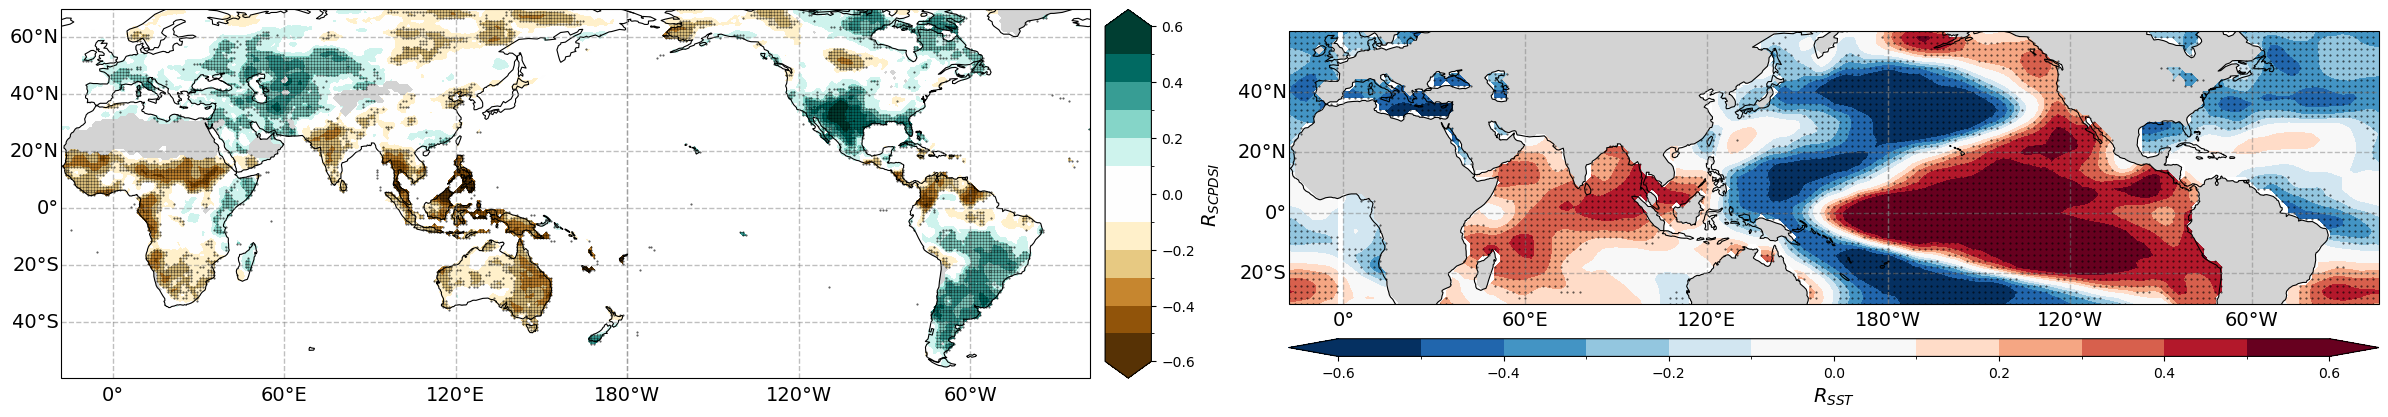

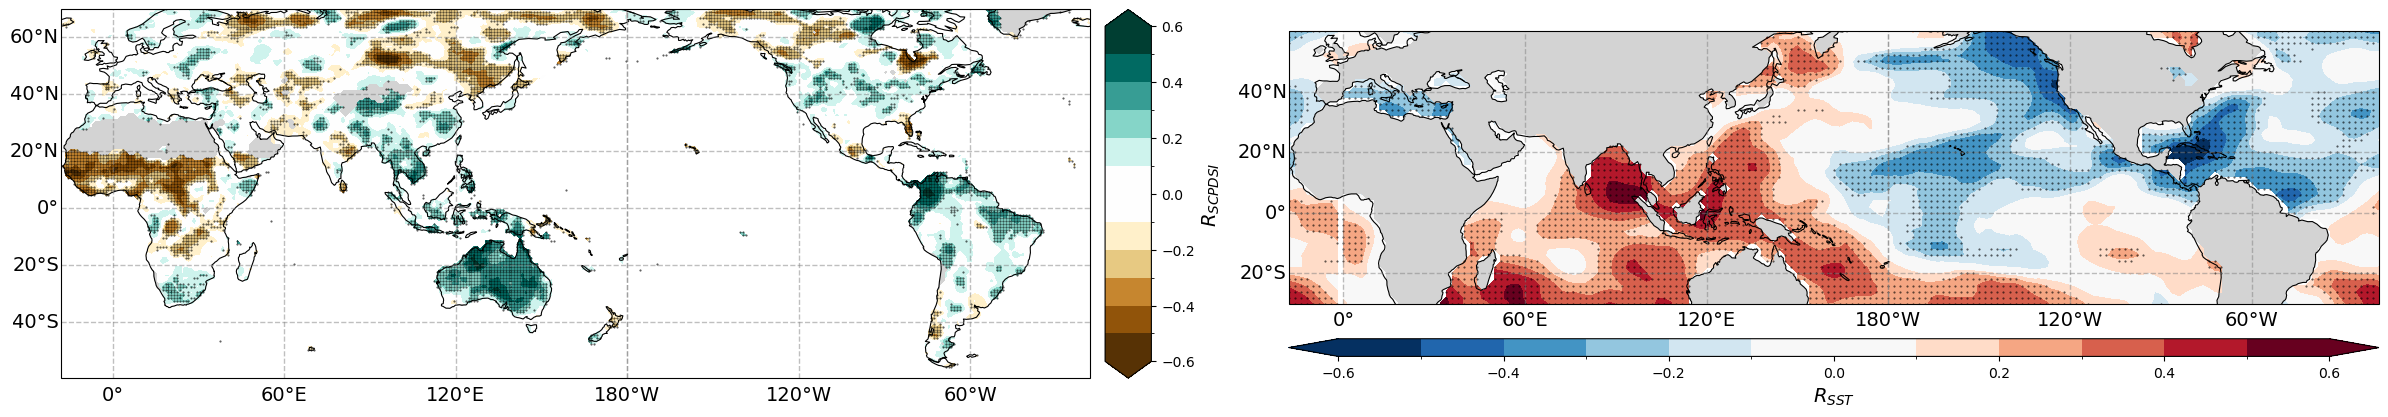

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import nclcmaps

# Define your modes and data
modes = [0, 1]
SST_yearly = SST_detrended_array
SCPDSI_yearly = SCPDSI_detrened_array

# Load colormaps
cmap1 = nclcmaps.cmap('CBR_coldhot')
cmap2 = nclcmaps.cmap('CBR_drywet')

# Define plotting function
def plot_correlations(mode, TU, TV, SCPDSI_yearly, SST_yearly):
    fig, ax = plt.subplots(1, 2, figsize=(24,16), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=162)})

    # Plot SCPDSI correlations on ax[0]
    ax[0].coastlines(linewidth=0.8)
    ax[0].add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
    set_gridlines(ax[0])
    
    correlations_scpdsi = calculate_correlations(TU * -1, SCPDSI_yearly)
    cf2 = correlations_scpdsi.plot.contourf(ax=ax[0], transform=ccrs.PlateCarree(), robust=True,
                                            levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                            cmap=cmap2, extend='both')
    
    pval_scpdsi = calculate_pval(TU * -1, SCPDSI_yearly)
    plot_significant_areas(ax[0], pval_scpdsi)

    # Plot SST correlations on ax[1]
    ax[1].coastlines(linewidth=0.8)
    ax[1].add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
    set_gridlines(ax[1])
    
    correlation_sst = calculate_correlations(TV * -1, SST_yearly)
    cf = correlation_sst.plot.contourf(ax=ax[1], transform=ccrs.PlateCarree(), robust=True,
                                       levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                       cmap=cmap1, extend='both')
    
    pval_sst = calculate_pval(TV * -1, SST_yearly)
    plot_significant_areas(ax[1], pval_sst)

    # Add colorbars
    add_colorbar(fig, ax[0], cf2, orientation='vertical', label=r'$R_{SCPDSI}$')
    add_colorbar(fig, ax[1], cf, orientation='horizontal', label=r'$R_{SST}$')
    plt.savefig(f"mode{mode}_full_period_new.pdf",dpi = 600)
    plt.savefig(f"mode{mode}_full_period_new.png",dpi = 600)
    


    plt.tight_layout()
    plt.show()

# Helper functions
def set_gridlines(axis):
    """Set gridlines for the given axis."""
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    # specify labels for gridlines at end points

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # gl.ylocator = mticker.FixedLocator([-30, -15, 0, 30, 60])
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    axis.grid(True)

def plot_significant_areas(axis, pval):
    """Plot significant areas where p-values are less than 0.05."""
    lons, lats = np.meshgrid(pval.lon, pval.lat)
    sig_area = np.where(pval < 0.05)
    axis.scatter(lons[sig_area], lats[sig_area], marker='.', s=1, c='k', alpha=0.7, transform=ccrs.PlateCarree())

def add_colorbar(fig, axis, contour, orientation='vertical', label=''):
    """Add a colorbar to the axis."""
    divider = make_axes_locatable(axis)
    if orientation == 'vertical':
        cax = divider.append_axes("right", size="4.5%", pad=0.15, axes_class=plt.Axes)
    else:
        cax = divider.append_axes("bottom", size="6.5%", pad=0.35, axes_class=plt.Axes)
    cbar = fig.colorbar(contour, cax=cax, orientation=orientation)
    cbar.set_label(label, weight='bold', fontsize=14)

# Iterate over modes and plot
for mode in modes:
    TU = np.matmul(A, U[:, mode])
    TV = np.matmul(B, V[:, mode])
    plot_correlations(mode, TU, TV, SCPDSI_yearly, SST_yearly)


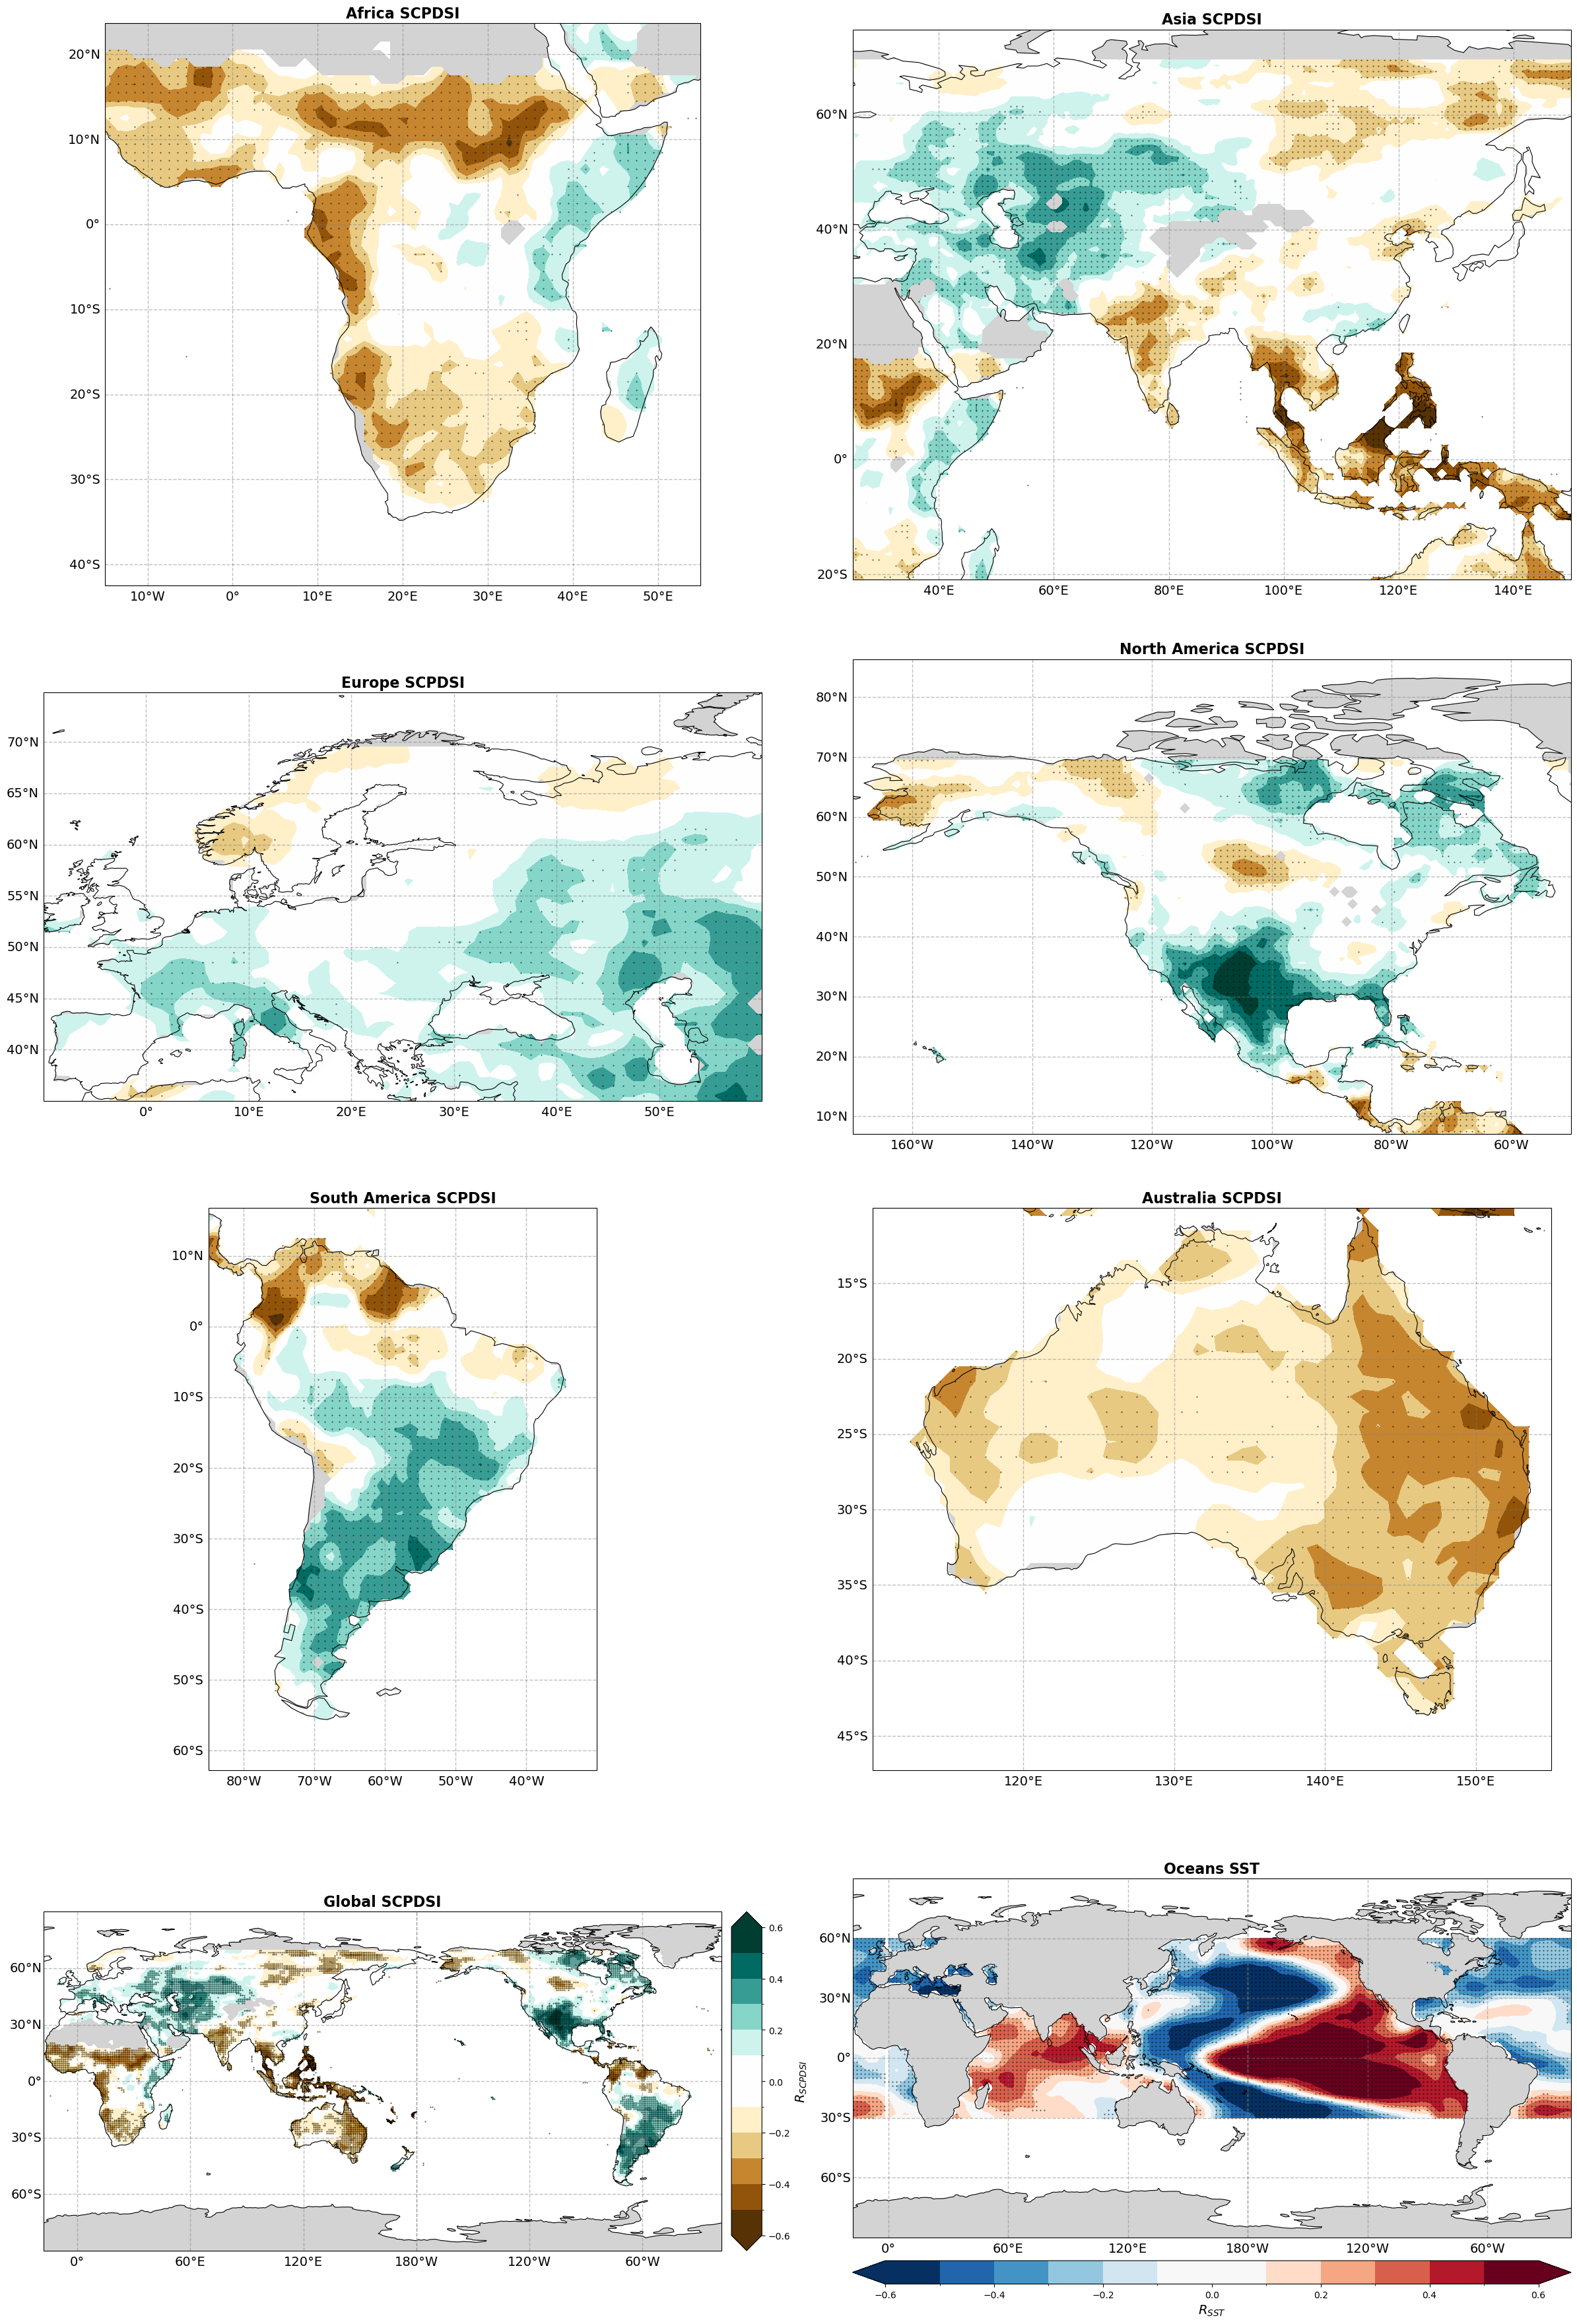

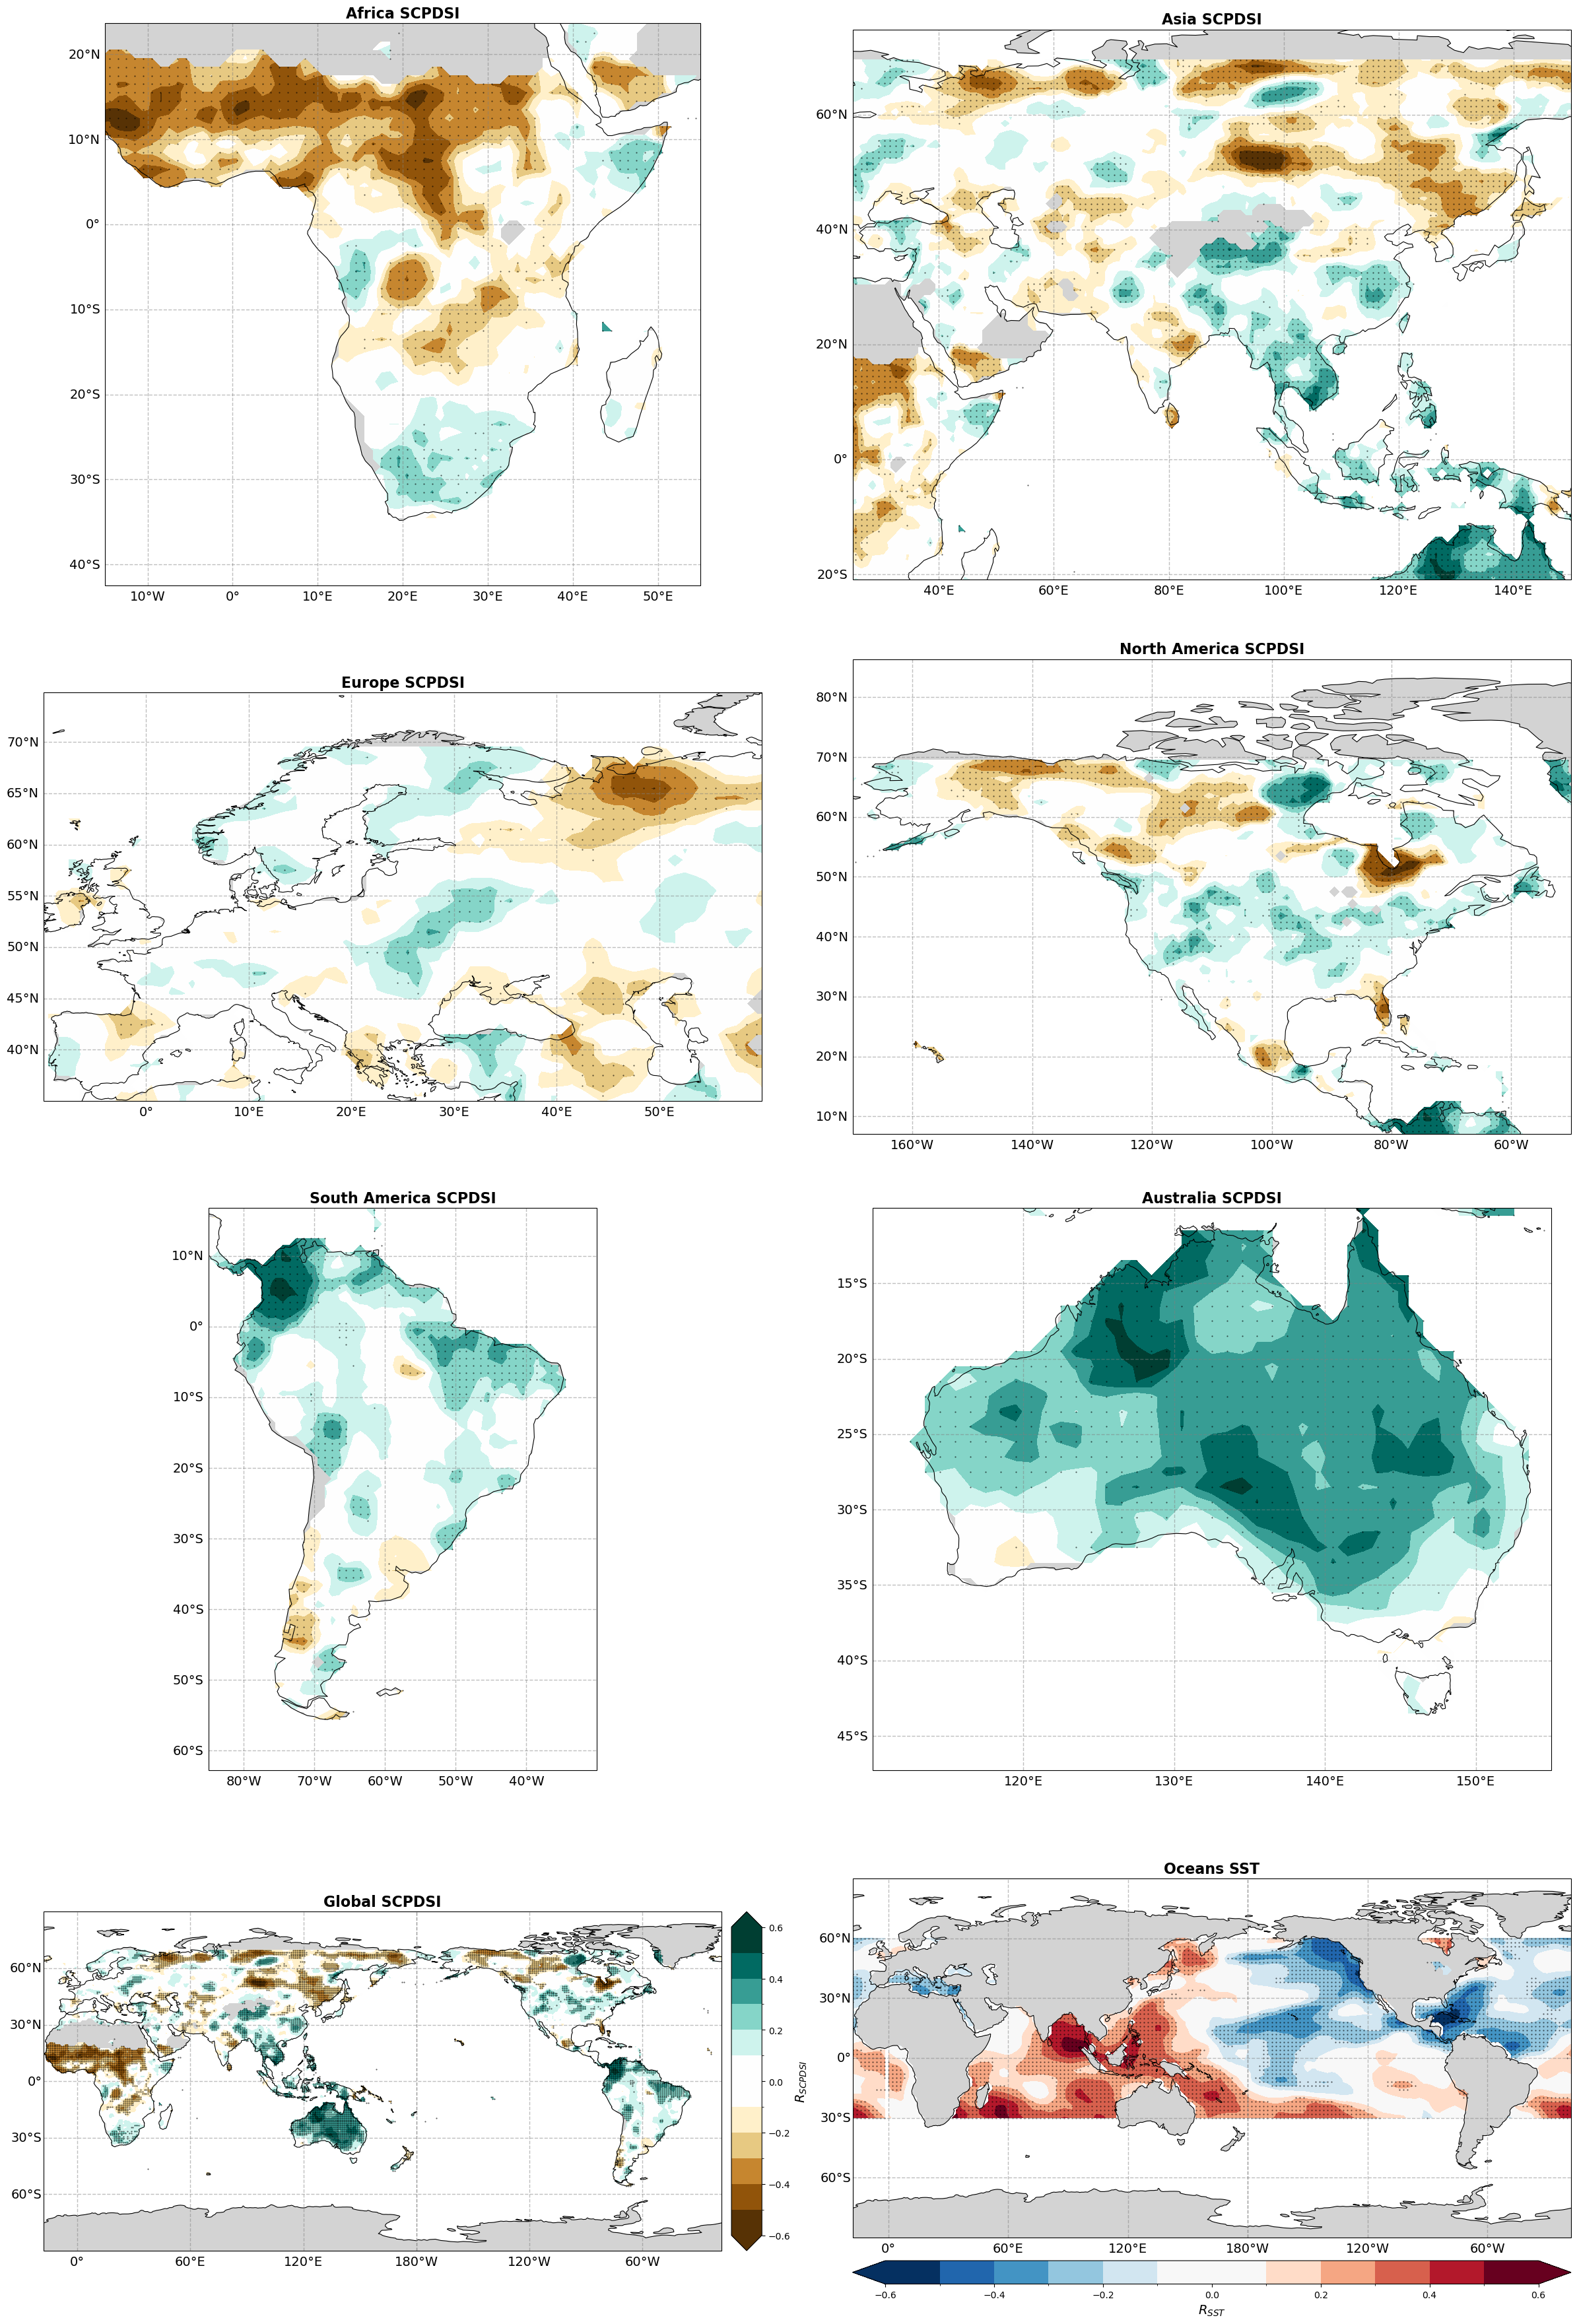

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import nclcmaps

# Define your modes and data
modes = [0, 1]
SST_yearly = SST_detrended_array
SCPDSI_yearly = SCPDSI_detrened_array

# Load colormaps
cmap1 = nclcmaps.cmap('CBR_coldhot')
cmap2 = nclcmaps.cmap('CBR_drywet')

# Extents for each continent
continent_extents = {
    'Africa': [-15, 55, -37, 20],
    'Asia': [25, 150, -10, 60],
    'Europe': [-10, 60, 35, 72],
    'North America': [-170, -50, 7, 83],
    'South America': [-85, -30, -60, 15],
    'Australia': [110, 155, -45, -10],
    'Global': [-180, 180, -90, 90]  # Oceans will cover the entire globe for simplicity
}

# Define the modified plotting function
def plot_correlations_per_continent(mode, TU, TV, SCPDSI_yearly, SST_yearly, continent_extents):
    fig, axes = plt.subplots(4, 2, figsize=(24, 36), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=162)})
    axes = axes.flatten()

    for i, (continent, extent) in enumerate(continent_extents.items()):
        ax = axes[i]
        ax.set_extent(extent)
        ax.coastlines(linewidth=0.8)
        ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
        set_gridlines(ax)
        
        # Plot SCPDSI correlations
        correlations_scpdsi = calculate_correlations(TU * -1, SCPDSI_yearly)
        cf2 = correlations_scpdsi.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), robust=True,
                                                levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                                cmap=cmap2, extend='both')
        
        pval_scpdsi = calculate_pval(TU * -1, SCPDSI_yearly)
        plot_significant_areas(ax, pval_scpdsi)

        ax.set_title(f"{continent} SCPDSI", fontsize=16, weight='bold')

    # Add colorbars
    add_colorbar(fig, axes[-2], cf2, orientation='vertical', label=r'$R_{SCPDSI}$')
    
    # Plot SST correlations in the last subplot for oceans
    ax = axes[-1]
    ax.set_extent(continent_extents['Global'])
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
    set_gridlines(ax)

    correlation_sst = calculate_correlations(TV * -1, SST_yearly)
    cf = correlation_sst.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), robust=True,
                                       levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                       cmap=cmap1, extend='both')
    
    pval_sst = calculate_pval(TV * -1, SST_yearly)
    plot_significant_areas(ax, pval_sst)
    ax.set_title(f"Oceans SST", fontsize=16, weight='bold')

    add_colorbar(fig, ax, cf, orientation='horizontal', label=r'$R_{SST}$')

    plt.savefig(f"mode{mode}_continents.pdf", dpi=600)
    plt.savefig(f"mode{mode}_continents.png", dpi=600)

    plt.tight_layout()
    plt.show()

# Iterate over modes and plot
for mode in modes:
    TU = np.matmul(A, U[:, mode])
    TV = np.matmul(B, V[:, mode])
    plot_correlations_per_continent(mode, TU, TV, SCPDSI_yearly, SST_yearly, continent_extents)

